# Segmenting and featurizing CMDs

We want to turn a color-magnitude diagram, which is essentially a point cloud in two dimensions (color and magnitude; but potentially in more dimensions if additional bands are used) into a set of features that can be thrown into a classifier or a regressor. An application would be tell us if there are multiple populations or to predict relevant properties (age, metallicity, distance...). Intuitively, segmenting the CMD into pieces that have a physical meaning  such as the HB, RGB, MS, BSS etc. would help. This is usually not done automatically as far as I know.

Below I introduce a new approach to segment the CMD. Later on we will extract features from each segment.


### Topological data analysis

Directly clustering or doing anomaly detection with e.g. [isolation forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) is not cutting it.

Anyway, I stumbled upon something that may do better: [topological data analysis](https://www.quantmetry.com/blog/topological-data-analysis-with-mapper/). There is already a [package](https://scikit-tda.org). Detailed theory [here](https://arxiv.org/pdf/1904.11044.pdf).

A picture is worth $10^3$ words:
![mapper](mapper.png)

This is the mapper algorithm. It's local clustering, in a sense. And it preserves the topological properties (e.g. holes) of the clusters it finds. Local clustering is important to us if we want to find structures that are _more densely clustered together than the background_. This is something that does not happen if we used e.g. DBSCAN right away: _eps_ and _min_samples_ set a density threshold once and for all for the whole dataset.

Anyway let's unpack this step by step:

* You start from some high dimensional feature space (CMDs are far from high dimensional, but they will do to illustrate the process; we might throw in other variables later).
* You apply a function that sends this space into one dimension. It does not have to be any particular function, you can choose it as you like. We call it the _lens_. In the picture above it's just projecting to one coordinate.
* You cover the lens codomain (in our case a subst of the real line) with overlapping intervals
* You look at the points in the high dimensional space that got sent to any given interval (i.e. the pre-image of the interval), and cluster them with you favourite clustering algorithm
* Every cluster becomes a node in a graph
* Nodes corresponding to clusters from different intervals that share at least one point (remember that the intervals overlap) get linked to each other
* You obtained a graph that shares some topological properties with the original high dimensional data
* We can now play with the graph

In particular each node of the graph corresponds to a cluster of points that share the same value of the lens. If the lens is an isolation forest score, then these are levels of isolatedness. That word does not exist, so let's say density. The graph may have more than one connected component. Hopefully each connected component corresponds to a branch of the CMD.

In [1]:
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import kmapper as km
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import LocalOutlierFactor
from kmapper.jupyter import display
from sklearn.ensemble import IsolationForest
import pandas as pd
from sklearn.preprocessing import RobustScaler
from networkx import adjacency_matrix
from sknetwork.topology import get_connected_components

#to make a scikit-learn compatible classifier class, following here https://scikit-learn.org/stable/developers/develop.html
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.neighbors import NearestNeighbors

Let's read and scale a test CMD to which we also add some contamination for realism

In [2]:
def contaminate(CMD, fraction = 0.3):
    js = np.random.choice(range(CMD.shape[0]), replace = False, size = int(np.round(fraction*CMD.shape[0])))
    for i in range(CMD.shape[1]):
        m = CMD.iloc[:,i].min()
        M = CMD.iloc[:,i].max()
        contaminants = m + np.random.uniform(size = CMD.shape[0])*(M - m)
        for j in js:
            CMD.iloc[j,i] = contaminants[j]
    return CMD

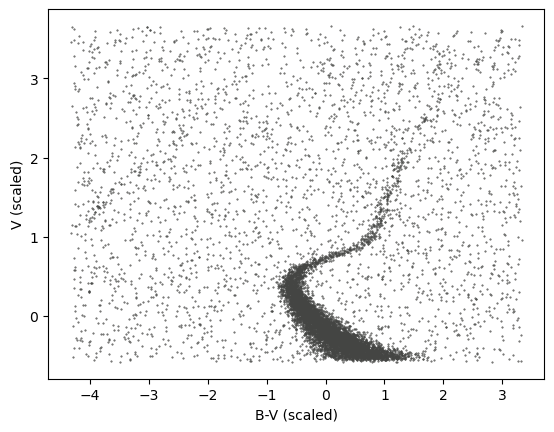

In [3]:
rs = RobustScaler()
CMD = contaminate(pd.read_csv('prova.csv')[['V1', 'V2']])
X = CMD.transpose()
X = rs.fit_transform(CMD)
plt.scatter(X[:,1], -X[:,0], s = 0.2, color = "#444543")
plt.xlabel("B-V (scaled)")
plt.ylabel("V (scaled)")
plt.show()

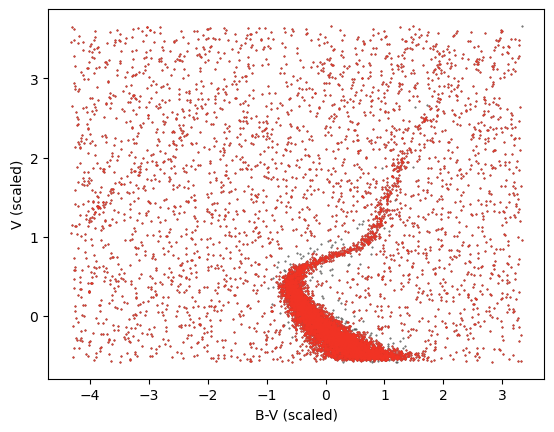

In [4]:
lol = LocalOutlierFactor(n_neighbors=10).fit_predict(X) 
isout = lol==-1
plt.scatter(X[:,1], -X[:,0], s = 0.2, color = "#444543")
plt.scatter(X[~isout,1], -X[~isout,0], s = 0.2, color = "#F23324")
plt.xlabel("B-V (scaled)")
plt.ylabel("V (scaled)")
plt.show()

In the following we will need to choose a clustering method to apply to the pre-images of the intervals that cover the image of our dataset thorugh the lens. Since each pre-image corresponds to a range in density (because the lens is the isolation forest score) we want to apply DBSCAN with _eps_ and _min_samples_ adequate to that level of the density. If we just pass a DBSCAN instance to the mapper (see below) we will not have this, because _eps_ and _min_samples_ will be set once an for all. So I create a new classifier, which is just a wrapper to DBSCAN, that runs DBSCAN with an _eps_ that is a multiple of the minimum nearest neighbor distance, while I leave _min_samples_fixed_. We can tune this later on to see what happens.

In [5]:
class CustomDBSCAN(BaseEstimator, ClassifierMixin):

    def __init__(self, demo_param='demo'):
         self.demo_param = demo_param

    def fit(self, X, y=None):
        self.X_ = X
        return self

    def fit_predict(self, X):
        self.fit(X)
        check_is_fitted(self)
        X = check_array(X)
        dbscan = DBSCAN(min_samples=4)#int(0.02*X.shape[0]))
        #labels = -np.ones(X.shape[0]) #we will throw away 20% of the points
        #selected = np.random.uniform(size=len(labels)) < 0.8
        #labels[selected] = dbscan.fit_predict(X[selected,:])
        labels = dbscan.fit_predict(X)
        if(labels.max()<4): #if dbscan finds only one group then throw everything away
            labels = -np.ones(X.shape[0])
        return labels       

In [6]:
tc = CustomDBSCAN()
tc.fit_predict(X).max()

-1.0

Interestingly, this custom version of DBSCAN applied to the whole dataset finds no clusters ($-1$ represents noise points in the output of the predict method from DBSCAN). This is not an issue, because the minimum nearest neighbor distance on the whole dataset is, well... very small.

Now let's finally apply the mapper algorithm (in its KeplerMapper implementation) to our data.

In [7]:
from hdbscan import HDBSCAN

def kmapper_CMD(d, n_cubes=20, isolation_forest_n_estimators = 1000, visualize_in_notebook = False, verbose=3):
    mapper = km.KeplerMapper(verbose=verbose) #verbosity = 3 means see all
    if isinstance(d, pd.DataFrame):
        data = d.to_numpy()
    else:
        data = d
    #isof = IsolationForest(random_state=888, n_estimators=isolation_forest_n_estimators).fit(data) 
    isoscore = np.random.uniform(size=data.shape[0]) #data[:,0] #isof.score_samples(data)
    cover = km.Cover(n_cubes=n_cubes, perc_overlap=0.25)
    graph = mapper.map(isoscore, data, cover=cover, clusterer=HDBSCAN()) #use our custom DBSCAN
    _ = mapper.visualize(graph, path_html="keplermapper_output.html",
                 title="CMD")
    if (visualize_in_notebook):
        display("keplermapper_output.html") #visualize the graph directly in the notebook; it's ugly
    return graph, isoscore

n_cubes = 20
graph, isoscore = kmapper_CMD(X, n_cubes=n_cubes)

KeplerMapper(verbose=3)
Mapping on data shaped (10000, 2) using lens shaped (10000,)

Minimal points in hypercube before clustering: 5
Creating 20 hypercubes.
   > Found 8 clusters in hypercube 0.
   > Found 8 clusters in hypercube 1.
   > Found 13 clusters in hypercube 2.
   > Found 8 clusters in hypercube 3.
   > Found 10 clusters in hypercube 4.
   > Found 7 clusters in hypercube 5.
   > Found 7 clusters in hypercube 6.
   > Found 6 clusters in hypercube 7.
   > Found 8 clusters in hypercube 8.
   > Found 13 clusters in hypercube 9.
   > Found 11 clusters in hypercube 10.
   > Found 10 clusters in hypercube 11.
   > Found 10 clusters in hypercube 12.
   > Found 8 clusters in hypercube 13.
   > Found 9 clusters in hypercube 14.
   > Found 13 clusters in hypercube 15.
   > Found 10 clusters in hypercube 16.
   > Found 7 clusters in hypercube 17.
   > Found 10 clusters in hypercube 18.
   > Found 11 clusters in hypercube 19.

Created 137 edges and 187 nodes in 0:00:00.394334.
Wrote vis

Now we take the graph from the mapper and find the connected components. For each node we then take the corresponding stars and pool them all together. So the stars corresponding to nodes in each connected component are selected as our group anomalies. These do not include all the stars in the graph because a large fraction of the stars is lost by being labelled a noise point by DBSCAN. This is intended behavior. 

/var/folders/8w/66mbmptd4ws3j45r5hp0c6w80000gn/T/ipykernel_2294/3360923907.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  am_iso = adjacency_matrix(nx_graph_iso)


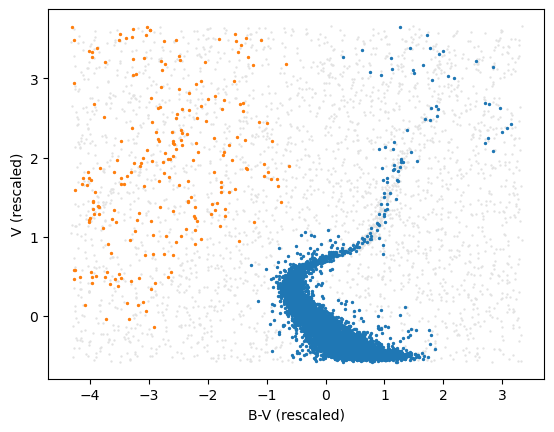

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51], dtype=int32),
 array([ 1, 11,  3, 33,  1,  1,  1,  1,  1,  1, 17,  1,  2,  1,  1,  7,  6,
         1,  1,  2,  1,  5,  1,  2,  3,  7,  1,  1,  1,  1, 14,  6,  1,  3,
         2,  1,  1,  6,  6,  2,  1, 14,  2,  2,  2,  2,  1,  1,  1,  1,  1,
         1]))

In [8]:
nx_graph_iso = km.adapter.to_nx(graph)
am_iso = adjacency_matrix(nx_graph_iso)
labels_iso = get_connected_components(am_iso)
node_counts_by_component = np.unique(labels_iso, return_counts=True)
cutoff_number_of_nodes_in_component = np.partition(node_counts_by_component[1], -3)[-3]

plt.scatter(X[:,1], -X[:,0], s = 0.5, color = "#E2E2E2")
plt.xlabel("B-V (rescaled)")
plt.ylabel("V (rescaled)")
for j in range(2):
    for h in range(j):
        for i in range(labels_iso.max()+1):
            if (labels_iso==i).sum() > cutoff_number_of_nodes_in_component: #plot only the connected component with most nodes
                cc = np.unique(np.concatenate([np.array(list(graph['nodes'].values())[k])
                                  for k in np.arange(len(labels_iso))[labels_iso==i]], axis=0))
                plt.scatter(X[cc,j], -X[cc,h], s = 2)
        plt.show()

node_counts_by_component

Compare with plain HDBSCAN

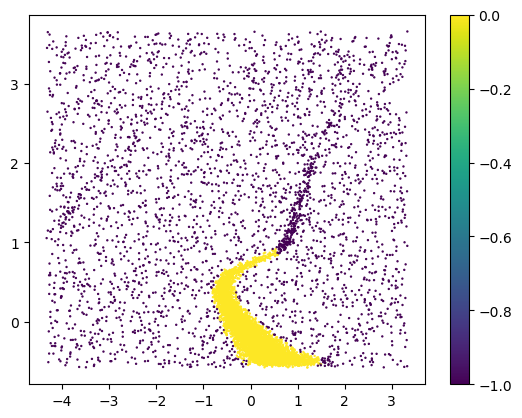

array([ 0, -1, -1, ...,  0,  0, -1])

In [9]:
o = HDBSCAN().fit_predict(X)
number_stars_in_group = np.unique(o, return_counts=True)
cutoff_number_stars_in_group = np.partition(number_stars_in_group[1], -3)[-3]
small_groups = (number_stars_in_group[0])[number_stars_in_group[1]<=cutoff_number_stars_in_group]
big_groups = (number_stars_in_group[0])[number_stars_in_group[1]>cutoff_number_stars_in_group]
for i in small_groups:
     o[o==i] = -1
for i in big_groups:
     o[o==i] = -1+np.arange(len(big_groups))[big_groups==i]
plt.scatter(X[:,1], -X[:,0], s = 0.5, c = o)

plt.colorbar()
plt.show()
o

In [10]:
am_iso

<187x187 sparse matrix of type '<class 'numpy.int64'>'
	with 274 stored elements in Compressed Sparse Row format>

In [11]:
from networkx import laplacian_spectrum
spectrum = laplacian_spectrum(nx_graph_iso)

<class 'networkx.utils.decorators.argmap'> compilation 4:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


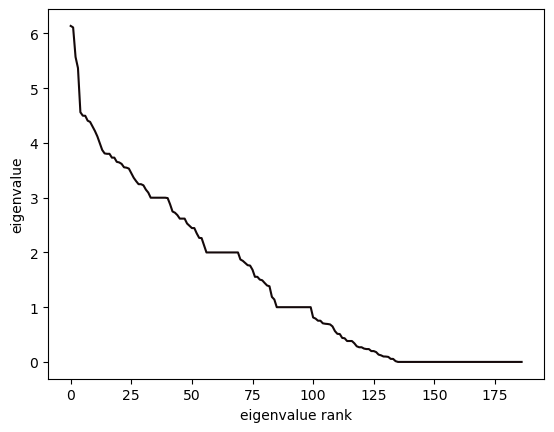

In [12]:
plt.plot(np.flip(np.arange(len(spectrum))), spectrum, color = "#14090A")
plt.xlabel('eigenvalue rank')
plt.ylabel('eigenvalue')

plt.show()

Maybe use the spectrum of the laplacian matrix as features for classification?
We definitely could use it on Stefano's star clusters to see whether they behave like the original simulations.
Also Yashar's suggestion that we could learn the projection function in the mapper algorithm needs a metric between graphs which we could define as the difference between the spectra (limited to the first eigenvalues possibly). We do not know how much a spectrum uniquely identifies a graph though